## Coursera's IBM Applied Data Science: Capstone Project

### Analysis of Singapore's Premium Product Shop Placement

*Kar Wai Lim*  
4 Jan 2020

This notebook accommpanies the report from https://github.com/karwailim/Coursera_Capstone/blob/master/Capstone_Project.pdf

#### Import Libraries

In [1]:
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner

# for clustering of data using K-means
from sklearn.cluster import KMeans
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

import folium # plotting library

#### Load data from URA

In [2]:
URA_data = '../data/URA_rental/cleaned_condo_rental_sg.csv'

In [3]:
rent = pd.read_csv(URA_data)

In [4]:
# data processing: remove area outside of Singapore
rent = rent[rent.latitude < 1.5]
rent = rent[rent.longitude > 100]

In [5]:
# number of data and feature size
rent.shape

(174780, 9)

In [6]:
rent.sample(3)

,Condo,Street,Postal,Bedrooms,Rent,Area,Lease Date,latitude,longitude
123668,CHANGI COURT,UPPER CHANGI ROAD EAST,16,3,2750,1100 to 1200,Jul-2015,1.343455,103.962987
167731,TOH TUCK LODGE,TOH TUCK ROAD,21,3,2900,2400 to 2500,Mar-2016,1.339700,103.766171
7604,REFLECTIONS AT KEPPEL BAY,KEPPEL BAY VIEW,4,2,5643,1200 to 1300,May-2015,1.266614,103.810360


Create additional column: Rent divided by Bedrooms

In [7]:
# check whether there's condo with zero bedroom
rent.query('Bedrooms == 0').size

0

In [8]:
rent['rent_per_room'] = rent['Rent'] / rent['Bedrooms']

In [9]:
rent.sample(3)

,Condo,Street,Postal,Bedrooms,Rent,Area,Lease Date,latitude,longitude,rent_per_room
63265,URBANA,RIVER VALLEY CLOSE,9,3,5600,1300 to 1400,Apr-2017,1.295304,103.837722,1866.666667
76789,THOMSON 800,THOMSON ROAD,11,3,3900,1400 to 1500,Dec-2014,1.340663,103.837062,1300.000000
127872,DOUBLE BAY RESIDENCES,SIMEI STREET 4,18,2,2700,900 to 1000,Feb-2017,1.341269,103.956287,1350.000000


In [10]:
# quick summary of the dataset
rent.describe()

,Postal,Bedrooms,Rent,latitude,longitude,rent_per_room
count,174780.000000,174780.000000,174780.000000,174780.000000,174780.000000,174780.000000
mean,12.958823,2.390228,3936.064870,1.321709,103.847339,1760.910481
std,6.370586,0.903958,2217.619767,0.033696,0.055617,805.683770
min,1.000000,1.000000,700.000000,1.239758,103.705984,233.333333
25%,9.000000,2.000000,2600.000000,1.298893,103.816782,1166.666667
50%,12.000000,2.000000,3300.000000,1.314499,103.842744,1550.000000
75%,18.000000,3.000000,4500.000000,1.341956,103.885038,2125.000000
max,28.000000,8.000000,48000.000000,1.448268,103.970189,14000.000000


#### Use API to query data from Foursquare

In [108]:
CLIENT_ID = 'xxx' # your Foursquare ID
CLIENT_SECRET = 'xxx' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 50                  # maximum allowable number is 50
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: xxx
CLIENT_SECRET:xxx


In [59]:
# latitude and longitude for Singapore
latitude, longitude = (1.290270, 103.851959)

In [60]:
# query premium product from foursquare
search_query = 'Premium|Luxury'
radius = 25000                      # search within 25km radius
print(search_query + ' .... OK!')

Premium|Luxury .... OK!


perform multiple searches across Singapore

In [61]:
min_lat, max_lat = rent['latitude'].min(), rent['latitude'].max()
min_lon, max_lon = rent['longitude'].min(), rent['longitude'].max()

In [62]:
%%time
dataframe = pd.DataFrame()

for lat in np.linspace(min_lat, max_lat, 7):
    for lon in np.linspace(min_lon, max_lon, 7):
        url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, lat, lon, VERSION, search_query, radius, LIMIT)
        results = requests.get(url).json()
        
        # assign relevant part of JSON to venues
        venues = results['response']['venues']

        # tranform venues into a dataframe
        df = json_normalize(venues)
        dataframe = dataframe.append(df, ignore_index=True, sort=False)
        

CPU times: user 1.93 s, sys: 118 ms, total: 2.05 s
Wall time: 1min 33s


In [63]:
# remove duplicate from data
dataframe = dataframe.drop_duplicates('id')

In [65]:
dataframe.shape

(239, 19)

In [104]:
dataframe.sample(3)

,id,name,categories,referralId,hasPerk,location.address,location.crossStreet,location.lat,location.lng,location.labeledLatLngs,location.distance,location.cc,location.city,location.state,location.country,location.formattedAddress,location.postalCode,location.neighborhood,venuePage.id
1231,5e0330979ef6fe0008ff3ce0,New Balance Premium Factory Outlet,"[{'id': '4bf58dd8d48988d1f2941735', 'name': 'S...",v-1578157355,False,23 Serangoon Central #02-20/21,NaN,1.351021,103.872300,"[{'label': 'display', 'lat': 1.3510212, 'lng':...",3886,SG,Singapore,NaN,Singapore,"[23 Serangoon Central #02-20/21, 556083, Singa...",556083,NaN,NaN
908,4ea8c01099114a2b12263b94,Premium Auto Pte Ltd,"[{'id': '4bf58dd8d48988d124951735', 'name': 'A...",v-1578157344,False,7 Kaki Bukit Road 1 #01-08,Eunos Technolink,1.334391,103.901148,"[{'label': 'display', 'lat': 1.334391413289788...",3508,SG,Singapore,NaN,Singapore,[7 Kaki Bukit Road 1 #01-08 (Eunos Technolink)...,415937,NaN,NaN
1321,4d637b096973a35de6e3a7ea,Ryan  The Acorn Premium Kindergarten,"[{'id': '4bf58dd8d48988d1a0941735', 'name': 'C...",v-1578157359,False,Blk 713 Tampines St 71 #01-206 S520713,NaN,1.360026,103.937616,"[{'label': 'display', 'lat': 1.360026, 'lng': ...",2191,SG,NaN,NaN,Singapore,"[Blk 713 Tampines St 71 #01-206 S520713, Singa...",NaN,NaN,NaN


#### Clustering of rental data  
We look for areas correspond to residents who are willing to pay more in rental

In [18]:
# normalize the data for clustering
X = rent[['latitude', 'longitude', 'rent_per_room']]
X = (X - X.mean()) / X.std()

In [19]:
%%time
# set number of clusters
kclusters = 200

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(X)

CPU times: user 4min 7s, sys: 1min 42s, total: 5min 50s
Wall time: 4min 34s


In [20]:
rent['cluster_label'] = kmeans.labels_

In [21]:
area = rent[['latitude', 'longitude', 'rent_per_room', 'cluster_label']].groupby('cluster_label').mean()
area.sample(10)

,latitude,longitude,rent_per_room
cluster_label,,,
76,1.372828,103.943971,923.498281
86,1.281586,103.797353,1940.816738
52,1.315226,103.836804,1949.954229
156,1.343329,103.736232,1055.278290
44,1.325821,103.847764,1243.473325
51,1.376807,103.761314,1114.072310
77,1.344390,103.720323,1092.377764
22,1.351194,103.859967,1178.107835
65,1.368216,103.773291,1021.874181


In [22]:
avg_rent_per_room = area['rent_per_room'].median()
avg_rent_per_room

1681.6727172967885

In [23]:
rich_area = area[area.rent_per_room > avg_rent_per_room]

#### Display the Results

In [106]:
venues_map = folium.Map(location=[latitude, longitude], zoom_start=11) # generate map centred around the Conrad Hotel

# add a red circle marker to represent the Conrad Hotel
for lat, lng, label in zip(rich_area['latitude'], rich_area['longitude'], rich_area['rent_per_room']):
    folium.CircleMarker(
        [lat, lng],
        radius=15,
        color='red',
        popup=label,
        fill = True,
        fill_color='red',
        fill_opacity=0.2
    ).add_to(venues_map)

# add the Italian restaurants as blue circle markers
for lat, lng, label in zip(dataframe['location.lat'], dataframe['location.lng'], dataframe['name']):
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        color='blue',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.5
    ).add_to(venues_map)

# display map
venues_map

**REMARKS**  
1. Some premium or luxury stores from Malaysia and Indonesia is captured as we have used 25km radius in our queries.
2. Many of the luxury stores are found in the Downtown area and also in the airport, which is expected.
3. Similarly, condominiums that are of higher rents are found to be concentrated in the Downtown area.
4. The best areas to set up premium stores would be the rich areas with not many competitors (you can click the blue dots to see the store name)

##### Note  
The folium map may not renders correctly when viewed on the web, for your convenience, I replicated a screenshot of the map below

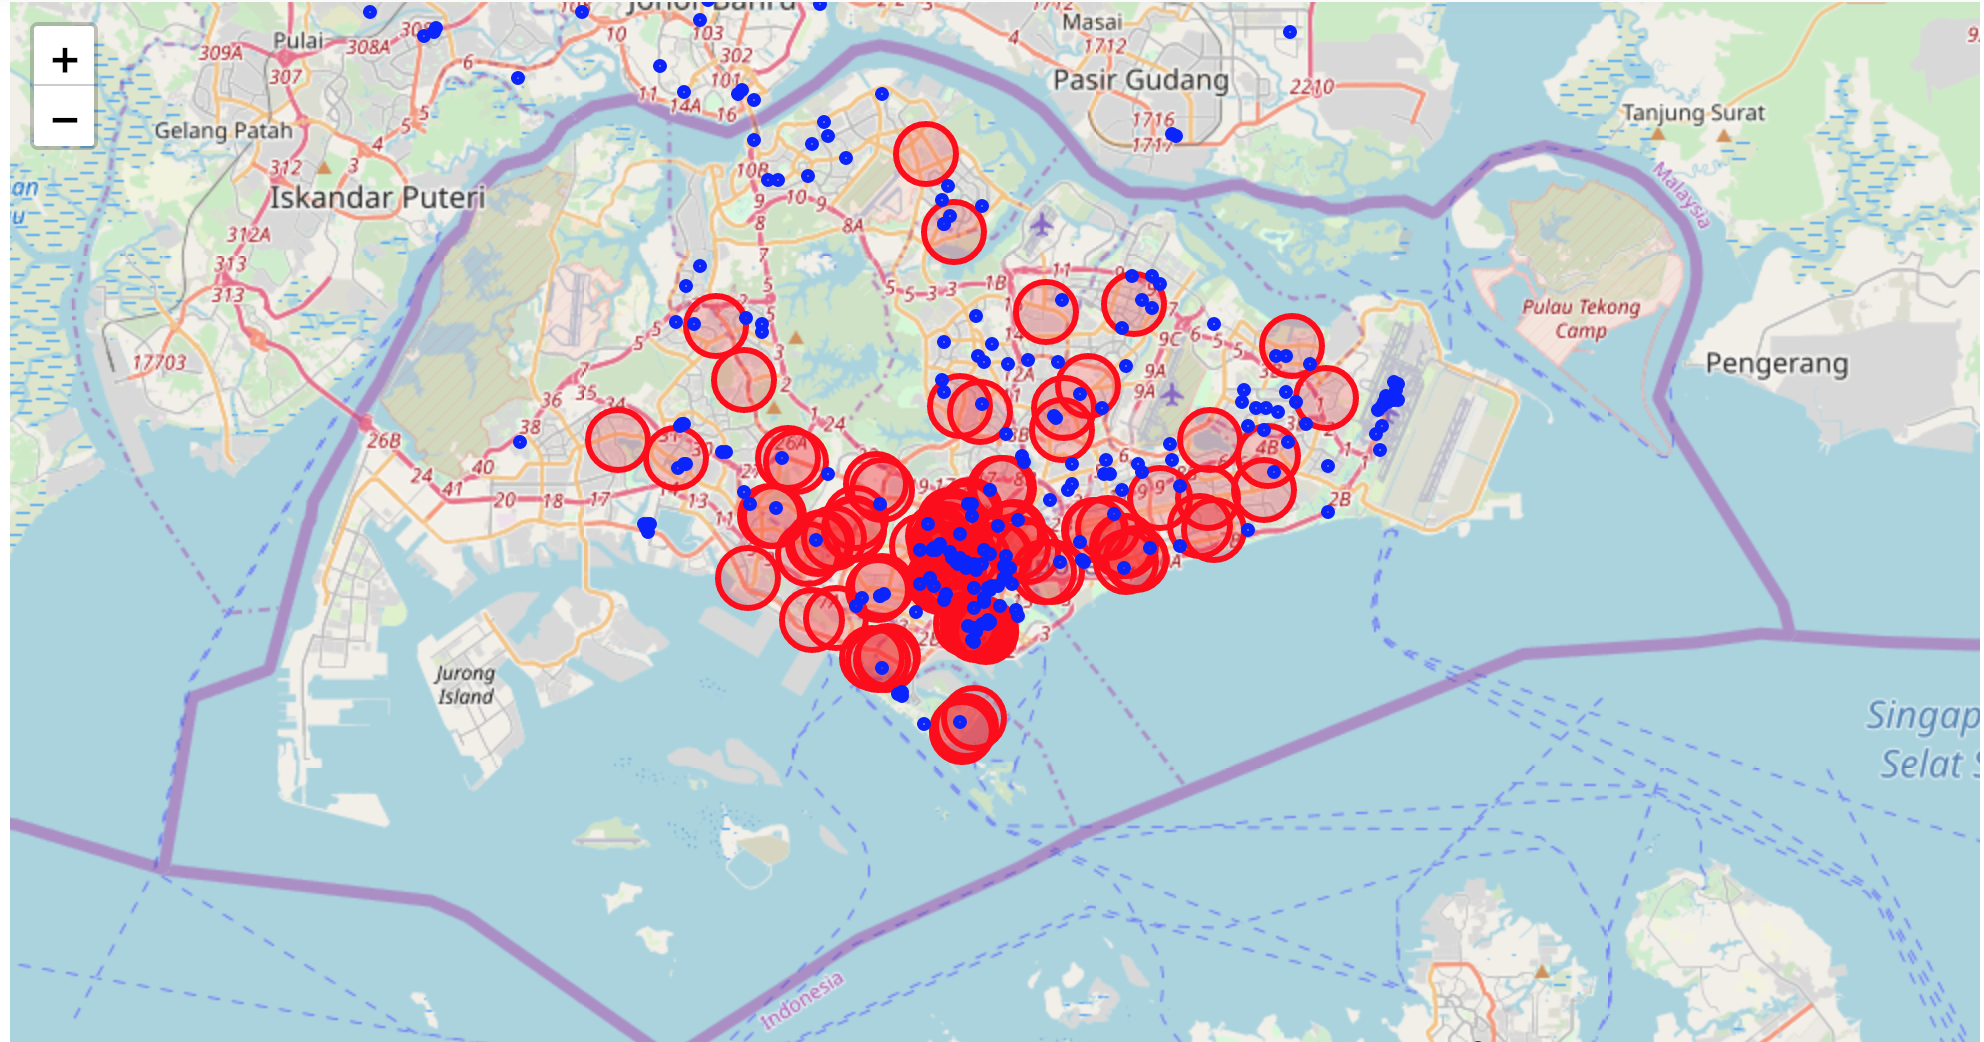

In [107]:
from IPython.display import Image
Image(filename='Capstone_Project.png') 